# Movie EDA Project
### Emily Krueger, Reid Majka
#### Flatiron School - Fall 2023

## Introduction

RE Corp. is excited to announce our latest venture RE Studios. As we devise our expansion into the film industry, we will address the following:

- How should we distribute capital and fund projects?
- What genres should we focus on to ensure we're producing highly profitable and highly rated films?
- How should we plan our annual release schedule to optimize profitability?
- What writers and directors should we aim to work with?

## Data Analysis and Cleaning

In [29]:
#all required imports
import pandas as pd
import sqlite3
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import gzip
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [30]:
#Data files extracting
FP1 = 'zippedData/rt.reviews.tsv.gz' #rotten tomatoes - no movie titles? where to get?
FP2 = 'zippedData/rt.movie_info.tsv.gz' #rotten tomatoes - no movie titles? where to get?
FP3 = 'zippedData/bom.movie_gross.csv.gz' #box office mojo studio and revenues / budgets for films - connect to other DB? This one vs. TN?
FP4 = 'zippedData/tmdb.movies.csv.gz' #the movies database - has vote counts and vote averages from the people vs. critics
FP5 = 'zippedData/tn.movie_budgets.csv.gz' #finanial data
#FP6 = 

#rotten tomatoes reviews file to pd_dataframe
with gzip.open(FP1, 'rt') as f1:
    rt_review = pd.read_csv(f1, delimiter='\t')

#rotten tomatoes info file to pd_dataframe   
with gzip.open(FP2, 'rt') as f2:
    rt_info = pd.read_csv(f2, delimiter='\t')    

#box office mojo file to pd_dataframe
with gzip.open(FP3, 'rt') as f3:
    bom_df = pd.read_csv(f3)

#The Movie DB file to pd_dataframe
with gzip.open(FP4, 'rt', encoding='utf-8') as f4:
    tmdb_df = pd.read_csv(f4, index_col='Unnamed: 0') #there is a column that holds the index value, setting as index
    
#The Numbers file to pd_dataframe
with gzip.open(FP5, 'rt', encoding='utf-8') as f5:
    tn_df = pd.read_csv(f5)
    

    
#merging the two rotten tomatoes databases together for analysis
total_rt = pd.merge(rt_info, rt_review, on='id', how='outer')

#IMDb file to SQL connection
zip_file_path = 'zippedData/im.db.zip'
extracted_db_path = 'im.db'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_db_path)
    
conn = sqlite3.connect("im.db/im.db")
cur = conn.cursor()

#### Reviewing the Dataframes

In [31]:
#reviewing the size of the data:

print('rotten tomatoes reviews: '+str(rt_review.shape))
print('rotten tomatoes info: '+str(rt_info.shape))
print('Box Office Mojo: '+str(bom_df.shape))
print('TMDb reviews: '+str(tmdb_df.shape))
print('TN DB reviews: '+str(tn_df.shape))


rotten tomatoes reviews: (54432, 8)
rotten tomatoes info: (1560, 12)
Box Office Mojo: (3387, 5)
TMDb reviews: (26517, 9)
TN DB reviews: (5782, 6)


### Cleaning the Databases

#### Reading and analyzing the SQL Database from IMDb

In [32]:
#import initial IMDb tables
imdbdf = pd.read_sql(
    """
    SELECT *
    FROM movie_basics
    JOIN movie_ratings
        USING(movie_id)
    JOIN movie_akas
        USING(movie_id)

"""
, conn
)
imdbdf

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,region,language,types,attributes,is_original_title
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,1,Sangharsh,IN,hi,None,alternative transliteration,0.0
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,2,Sunghursh,None,None,original,None,1.0
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,3,Sunghursh,IN,None,None,None,0.0
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,4,Sunghursh,IN,hi,None,alternative transliteration,0.0
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,5,Sungharsh,IN,hi,None,alternative spelling,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261801,tt9905462,Pengalila,Pengalila,2019,111.0,Drama,8.4,600,2,Sisterleaf,IN,en,None,literal English title,0.0
261802,tt9905462,Pengalila,Pengalila,2019,111.0,Drama,8.4,600,3,Pengalila,IN,None,None,None,0.0
261803,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.0,Drama,8.4,365,1,Padmavyuhathile Abhimanyu,None,None,original,None,1.0
261804,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.0,Drama,8.4,365,2,Pathmavyuhathile Abhimanyu,IN,ml,None,alternative spelling,0.0


In [33]:
# Clean IMDb to include records that include run time, records that were released in english speaking regions, records that have genre,
# records with at least 50 votes for rating, and runtime under 1300 minutes to remove outliers

imdbdf.dropna(subset=['runtime_minutes'], inplace=True)
imdbdf.drop(['is_original_title', 'attributes', 'types', 'language'], axis = 1, inplace=True)
regions = ['CA', 'US', 'GB', 'AU', 'IE', 'NZ']
imdbdf = imdbdf[imdbdf['region'].isin(regions)]
imdbdf.dropna(subset=['genres'], inplace=True)
imdbdf = imdbdf[imdbdf['numvotes'] >= 50].copy()
imdbdf.drop_duplicates(subset='movie_id', inplace=True)
imdbdf = imdbdf[imdbdf['runtime_minutes'] <= 1300.0 ].copy()
imdbdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18922 entries, 10 to 261779
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         18922 non-null  object 
 1   primary_title    18922 non-null  object 
 2   original_title   18922 non-null  object 
 3   start_year       18922 non-null  int64  
 4   runtime_minutes  18922 non-null  float64
 5   genres           18922 non-null  object 
 6   averagerating    18922 non-null  float64
 7   numvotes         18922 non-null  int64  
 8   ordering         18922 non-null  int64  
 9   title            18922 non-null  object 
 10  region           18922 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 1.7+ MB


<ipython-input-33-d473cf2b23a8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdbdf.dropna(subset=['genres'], inplace=True)


In [34]:
#import and define writers table, add count column for eventual grouping
writersdf = pd.read_sql(
    """
    SELECT movie_id, person_id as writer_id, primary_name as writer_name
    FROM writers
    JOIN persons
        USING(person_id)
"""
, conn
)

writersdf['count'] = 1
writersdf

,movie_id,writer_id,writer_name,count
0,tt0285252,nm0899854,Tony Vitale,1
1,tt0438973,nm0175726,Steve Conrad,1
2,tt0438973,nm1802864,Sean Sorensen,1
3,tt0462036,nm1940585,Bill Haley,1
4,tt0835418,nm0310087,Peter Gaulke,1
...,...,...,...,...
255866,tt8999892,nm10122246,Bradley T. Castle,1
255867,tt8999974,nm10122357,Daysi Burbano,1
255868,tt9001390,nm6711477,Bernard Lessa,1
255869,tt9004986,nm4993825,Fredrik Horn Akselsen,1


In [35]:
#check writers info 
writersdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255871 entries, 0 to 255870
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   movie_id     255871 non-null  object
 1   writer_id    255871 non-null  object
 2   writer_name  255871 non-null  object
 3   count        255871 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 7.8+ MB


In [36]:
#import and define directors table, add count column for eventual grouping
directorsdf = pd.read_sql(
    """
    SELECT movie_id, person_id as director_id, primary_name as director_name
    FROM directors
    JOIN persons
        USING(person_id)
"""
, conn
)
directorsdf['count'] = 1
directorsdf

,movie_id,director_id,director_name,count
0,tt0285252,nm0899854,Tony Vitale,1
1,tt0462036,nm1940585,Bill Haley,1
2,tt0835418,nm0151540,Jay Chandrasekhar,1
3,tt0835418,nm0151540,Jay Chandrasekhar,1
4,tt0878654,nm0089502,Albert Pyun,1
...,...,...,...,...
291166,tt8999974,nm10122357,Daysi Burbano,1
291167,tt9001390,nm6711477,Bernard Lessa,1
291168,tt9001494,nm10123242,Tate Nova,1
291169,tt9001494,nm10123248,Courtney Faye Powell,1


In [37]:
#create combined df with writers and directors listed for each movie
imdbwritersdf = pd.merge(imdbdf, writersdf, on='movie_id', how='left') 
imdbwritersdf2 = imdbwritersdf.groupby('movie_id')['writer_name'].agg(list).reset_index()

imdbdirectorsdf = pd.merge(imdbdf, directorsdf, on='movie_id', how='left') 
imdbdirectorsdf2 = imdbdirectorsdf.groupby('movie_id')['director_name'].agg(list).reset_index()

imdbdf = imdbdf.merge(imdbwritersdf2, on='movie_id', how='left')
imdbdf = imdbdf.merge(imdbdirectorsdf2, on='movie_id', how='left')
imdbdf

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,region,writer_name,director_name
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,2,The Other Side of the Wind,US,"[Orson Welles, Oja Kodar]","[Orson Welles, Orson Welles]"
1,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263,1,Joe Finds Grace,CA,[Anthony Harrison],[Anthony Harrison]
2,tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,7.6,53,3,Cooper and Hemingway: The True Gen,US,[John Mulholland],[John Mulholland]
3,tt0192528,Heaven & Hell,Reverse Heaven,2018,104.0,Drama,4.0,72,1,Heaven & Hell,US,[Stuart Paul],[Stuart Paul]
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18917,tt9815714,The Hard Way,The Hard Way,2019,92.0,Action,4.7,1214,1,The Hard Way,US,"[Thomas J. Churchill, Keoni Waxman]","[Keoni Waxman, Keoni Waxman]"
18918,tt9825006,Avant qu'on explose,Avant qu'on explose,2019,108.0,Comedy,6.9,50,1,Avant qu'on explose,CA,[Eric K. Boulianne],[Rémi St-Michel]
18919,tt9866344,Mon Ami Walid,Mon Ami Walid,2019,72.0,"Comedy,Drama",5.7,50,2,Mon ami Walid,CA,"[Adib Alkhalidey, Julien Lacroix]","[Adib Alkhalidey, Adib Alkhalidey]"
18920,tt9875852,The House Elf,Domovoy,2019,90.0,"Comedy,Family,Fantasy",5.8,50,2,The House Elf,US,[nan],[Evgeniy Bedarev]


In [38]:
#declare function to determine if the writer served as a director on the film
def check_wd_match(record):
    return 1 if any(name in record['director_name'] for name in record['writer_name']) else 0

imdbdf['wd_match'] = imdbdf.apply(check_wd_match, axis=1)

imdbdf

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,region,writer_name,director_name,wd_match
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,2,The Other Side of the Wind,US,"[Orson Welles, Oja Kodar]","[Orson Welles, Orson Welles]",1
1,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263,1,Joe Finds Grace,CA,[Anthony Harrison],[Anthony Harrison],1
2,tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,7.6,53,3,Cooper and Hemingway: The True Gen,US,[John Mulholland],[John Mulholland],1
3,tt0192528,Heaven & Hell,Reverse Heaven,2018,104.0,Drama,4.0,72,1,Heaven & Hell,US,[Stuart Paul],[Stuart Paul],1
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18917,tt9815714,The Hard Way,The Hard Way,2019,92.0,Action,4.7,1214,1,The Hard Way,US,"[Thomas J. Churchill, Keoni Waxman]","[Keoni Waxman, Keoni Waxman]",1
18918,tt9825006,Avant qu'on explose,Avant qu'on explose,2019,108.0,Comedy,6.9,50,1,Avant qu'on explose,CA,[Eric K. Boulianne],[Rémi St-Michel],0
18919,tt9866344,Mon Ami Walid,Mon Ami Walid,2019,72.0,"Comedy,Drama",5.7,50,2,Mon ami Walid,CA,"[Adib Alkhalidey, Julien Lacroix]","[Adib Alkhalidey, Adib Alkhalidey]",1
18920,tt9875852,The House Elf,Domovoy,2019,90.0,"Comedy,Family,Fantasy",5.8,50,2,The House Elf,US,[nan],[Evgeniy Bedarev],0


In [39]:
#declare function to determine if the writer is the only director on the film
def find_w_only_d(record):
    if record['wd_match'] == 1:
        return 2 if len(record['director_name']) == 1 else 1
    else:
        return 0

imdbdf['w_only_d'] = imdbdf.apply(find_w_only_d, axis=1)
imdbdf

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,region,writer_name,director_name,wd_match,w_only_d
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,2,The Other Side of the Wind,US,"[Orson Welles, Oja Kodar]","[Orson Welles, Orson Welles]",1,1
1,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263,1,Joe Finds Grace,CA,[Anthony Harrison],[Anthony Harrison],1,2
2,tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,7.6,53,3,Cooper and Hemingway: The True Gen,US,[John Mulholland],[John Mulholland],1,2
3,tt0192528,Heaven & Hell,Reverse Heaven,2018,104.0,Drama,4.0,72,1,Heaven & Hell,US,[Stuart Paul],[Stuart Paul],1,2
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18917,tt9815714,The Hard Way,The Hard Way,2019,92.0,Action,4.7,1214,1,The Hard Way,US,"[Thomas J. Churchill, Keoni Waxman]","[Keoni Waxman, Keoni Waxman]",1,1
18918,tt9825006,Avant qu'on explose,Avant qu'on explose,2019,108.0,Comedy,6.9,50,1,Avant qu'on explose,CA,[Eric K. Boulianne],[Rémi St-Michel],0,0
18919,tt9866344,Mon Ami Walid,Mon Ami Walid,2019,72.0,"Comedy,Drama",5.7,50,2,Mon ami Walid,CA,"[Adib Alkhalidey, Julien Lacroix]","[Adib Alkhalidey, Adib Alkhalidey]",1,1
18920,tt9875852,The House Elf,Domovoy,2019,90.0,"Comedy,Family,Fantasy",5.8,50,2,The House Elf,US,[nan],[Evgeniy Bedarev],0,0


In [40]:
#add column to count the number of directors
imdbdf['director_count'] = imdbdf['director_name'].apply(lambda x: len(x))

In [41]:
#create df that includes only films that have 1 director
imdbdf_onedir = imdbdf[imdbdf['director_count'] == 1]
imdbdf_onedir['director_name'] = imdbdf_onedir['director_name'].apply(lambda x: x[0])
imdbdf_onedir

<ipython-input-41-9a3fbfa6acf2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdbdf_onedir['director_name'] = imdbdf_onedir['director_name'].apply(lambda x: x[0])


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,region,writer_name,director_name,wd_match,w_only_d,director_count
1,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263,1,Joe Finds Grace,CA,[Anthony Harrison],Anthony Harrison,1,2,1
2,tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,7.6,53,3,Cooper and Hemingway: The True Gen,US,[John Mulholland],John Mulholland,1,2,1
3,tt0192528,Heaven & Hell,Reverse Heaven,2018,104.0,Drama,4.0,72,1,Heaven & Hell,US,[Stuart Paul],Stuart Paul,1,2,1
6,tt0285252,Life's a Beach,Life's a Beach,2012,100.0,Comedy,3.9,219,3,Jungle Juice,US,[Tony Vitale],Tony Vitale,1,2,1
7,tt0293069,Dark Blood,Dark Blood,2012,86.0,Thriller,6.6,1053,3,Dark Blood,US,[Jim Barton],George Sluizer,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18914,tt9626278,Fourteen,Fourteen,2019,94.0,Drama,6.7,74,2,Fourteen,US,[Dan Sallitt],Dan Sallitt,1,2,1
18915,tt9685652,Greyhound Attack,Greyhound Attack,2019,80.0,"Action,Drama,War",1.3,108,1,Stormbirds,GB,[Christopher Forbes],Christopher Forbes,1,2,1
18918,tt9825006,Avant qu'on explose,Avant qu'on explose,2019,108.0,Comedy,6.9,50,1,Avant qu'on explose,CA,[Eric K. Boulianne],Rémi St-Michel,0,0,1
18920,tt9875852,The House Elf,Domovoy,2019,90.0,"Comedy,Family,Fantasy",5.8,50,2,The House Elf,US,[nan],Evgeniy Bedarev,0,0,1


In [42]:
#create dataframe that includes only films that have multiple directors
imdbdf_multdir = imdbdf[imdbdf['director_count'] != 1]
imdbdf_multdir

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,region,writer_name,director_name,wd_match,w_only_d,director_count
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,2,The Other Side of the Wind,US,"[Orson Welles, Oja Kodar]","[Orson Welles, Orson Welles]",1,1,2
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1,1,5
5,tt0255820,Return to Babylon,Return to Babylon,2013,75.0,"Biography,Comedy,Drama",5.9,123,1,Return to Babylon,US,"[Alex Monty Canawati, Bruce Pitzer, Stanley Sh...","[Alex Monty Canawati, Alex Monty Canawati, Ale...",1,1,3
8,tt0312305,Quantum Quest: A Cassini Space Odyssey,Quantum Quest: A Cassini Space Odyssey,2010,45.0,"Adventure,Animation,Sci-Fi",5.1,287,1,2004: A Light Knight's Odyssey,US,"[Harry 'Doc' Kloor, Harry 'Doc' Kloor]","[Daniel St. Pierre, Harry 'Doc' Kloor]",1,1,2
12,tt0331312,This Wretched Life,This Wretched Life,2010,99.0,"Comedy,Drama",7.6,59,1,This Wretched Life,US,"[Frankie J. Mosca, Sal DeLucia, Ande Cira, Chr...","[Frankie J. Mosca, Frankie J. Mosca, Frankie J...",1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18912,tt9617456,For Sama,For Sama,2019,95.0,Documentary,8.8,51,2,For Sama,GB,[nan],"[Waad Al-Khateab, Edward Watts]",0,0,2
18913,tt9617546,I'm Just F*cking With You,I'm Just F*cking With You,2019,81.0,"Comedy,Horror",5.6,559,1,I'm Just F*cking With You,US,"[Scott Barkan, Gregg Zehentner]","[Adam Mason, Adam Mason]",0,0,2
18916,tt9783778,Adventures of Aladdin,Adventures of Aladdin,2019,87.0,"Adventure,Fantasy",1.7,389,2,Adventures of Aladdin,US,"[Glenn Campbell, Tammy Klein]","[Glenn Campbell, Glenn Campbell]",1,1,2
18917,tt9815714,The Hard Way,The Hard Way,2019,92.0,Action,4.7,1214,1,The Hard Way,US,"[Thomas J. Churchill, Keoni Waxman]","[Keoni Waxman, Keoni Waxman]",1,1,2


In [43]:
#defining first genre listed as primary, althought probably not the best way given genres likely isn't in any specific order
imdbdf['primary genre'] = imdbdf['genres'].apply(lambda x: x.split(',')[0])
imdbdf.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,region,writer_name,director_name,wd_match,w_only_d,director_count,primary genre
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,2,The Other Side of the Wind,US,"[Orson Welles, Oja Kodar]","[Orson Welles, Orson Welles]",1,1,2,Drama
1,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263,1,Joe Finds Grace,CA,[Anthony Harrison],[Anthony Harrison],1,2,1,Adventure
2,tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,7.6,53,3,Cooper and Hemingway: The True Gen,US,[John Mulholland],[John Mulholland],1,2,1,Documentary
3,tt0192528,Heaven & Hell,Reverse Heaven,2018,104.0,Drama,4.0,72,1,Heaven & Hell,US,[Stuart Paul],[Stuart Paul],1,2,1,Drama
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1,1,5,Action


In [44]:
df2.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'ordering',
       'title', 'region', 'writer_name', 'director_name', 'wd_match',
       'w_only_d', 'director_count', 'genre count'],
      dtype='object')

In [45]:
#explode genre so duplicated for each genre listed for each movie for enventual grouping by genre
df2 = imdbdf
df2['genres'] = df2['genres'].apply(lambda x: x.split(','))
df2 = df2.explode('genres')
df2.drop('primary genre', axis=1, inplace=True)
df2 = df2[df2['numvotes'] >= 1000].copy()
df2

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,region,writer_name,director_name,wd_match,w_only_d,director_count
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,2,The Other Side of the Wind,US,"[Orson Welles, Oja Kodar]","[Orson Welles, Orson Welles]",1,1,2
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,Action,1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1,1,5
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,Animation,1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1,1,5
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,Comedy,1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1,1,5
7,tt0293069,Dark Blood,Dark Blood,2012,86.0,Thriller,6.6,1053,3,Dark Blood,US,[Jim Barton],[George Sluizer],0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18907,tt9558612,PM Narendra Modi,PM Narendra Modi,2019,136.0,Drama,3.7,4057,1,PM Narendra Modi,US,"[Anirudh Chawla, Harsh Limbachiyaa, Vivek Ober...","[Omung Kumar, Omung Kumar, Omung Kumar, Omung ...",0,0,4
18908,tt9562694,Alien Warfare,Alien Warfare,2019,88.0,Action,2.6,1509,5,Alien Warfare,US,"[Ben Bailey, Dave Baker, Nathan Zoebl]","[Jeremiah Jones, Jeremiah Jones, Jeremiah Jones]",0,0,3
18908,tt9562694,Alien Warfare,Alien Warfare,2019,88.0,Sci-Fi,2.6,1509,5,Alien Warfare,US,"[Ben Bailey, Dave Baker, Nathan Zoebl]","[Jeremiah Jones, Jeremiah Jones, Jeremiah Jones]",0,0,3
18909,tt9573980,Leaving Neverland,Leaving Neverland,2019,240.0,Documentary,7.1,19632,4,Leaving Neverland,US,[nan],[Dan Reed],0,0,1


In [46]:
df2['genre count'] = 1
df2.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,region,writer_name,director_name,wd_match,w_only_d,director_count,genre count
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,2,The Other Side of the Wind,US,"[Orson Welles, Oja Kodar]","[Orson Welles, Orson Welles]",1,1,2,1
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,Action,1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1,1,5,1
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,Animation,1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1,1,5,1
4,tt0249516,Foodfight!,Foodfight!,2012,91.0,Comedy,1.9,8248,2,Foodfight!,US,"[Lawrence Kasanoff, Joshua Wexler, Brent V. Fr...","[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1,1,5,1
7,tt0293069,Dark Blood,Dark Blood,2012,86.0,Thriller,6.6,1053,3,Dark Blood,US,[Jim Barton],[George Sluizer],0,0,1,1


In [47]:
#groupby genre to analyze metrics by genre. include only genres that have at least 50 movies in the dataset
genredf = df2.groupby(by='genres').agg({'runtime_minutes': 'mean', 'averagerating': 'mean', 'numvotes':'sum', 'genre count': 'sum'})
genredf.sort_values(by='averagerating', ascending=False, inplace=True)
genredf = genredf[genredf['genre count'] >= 50]
genredf

,runtime_minutes,averagerating,numvotes,genre count
genres,,,,
Documentary,96.449139,7.269640,3268864,639
Biography,110.982014,6.952338,20632783,556
Sport,104.600000,6.894194,3415241,155
History,112.546125,6.877860,6966129,271
Music,105.856522,6.780435,5037391,230
War,111.241071,6.625893,2341930,112
Animation,92.014235,6.573310,14660864,281
Drama,105.867233,6.343025,108653119,3412
Romance,105.026906,6.198206,24318286,892


In [48]:
#include only writers whose films have at least 1000 rating votes (mean is around 15k. this eliminates films that were not widely distributed)
imdbwriters2 = imdbwritersdf[imdbwritersdf['numvotes'] >= 1000]

#groupby writer id to look at the average rating of each writers' films
writersratings = imdbwriters2.groupby('writer_id').agg({'runtime_minutes': 'mean', 'averagerating': 'mean', 'count': 'sum'})
writersratings.sort_values(by='averagerating', inplace=True, ascending=False)
writersratings

,runtime_minutes,averagerating,count
writer_id,,,
nm3591496,147.0,9.4,3.0
nm6041686,147.0,9.4,3.0
nm1919905,115.0,9.3,2.0
nm6856823,120.0,9.2,1.0
nm2119365,60.0,9.1,1.0
...,...,...,...
nm6805281,79.0,1.5,1.0
nm0229544,79.0,1.5,1.0
nm4669069,80.0,1.4,1.0


In [49]:
#inlcude only writers who have written at least 5 movies
writersratings.sort_values(by='count', ascending=False)
writersratings = writersratings[writersratings['count'] >= 5].copy()
writersratings

,runtime_minutes,averagerating,count
writer_id,,,
nm4160687,151.142857,8.242857,7.0
nm0634240,146.000000,8.160000,5.0
nm0598531,98.076923,7.800000,13.0
nm1158544,107.428571,7.771429,7.0
nm0800209,140.222222,7.766667,9.0
...,...,...,...
nm1726531,88.200000,4.120000,5.0
nm1726912,88.200000,4.120000,5.0
nm0915394,92.000000,4.080000,5.0


In [50]:
#add writer name to aggregated writer dataframe
writersratings = writersratings.merge(writersdf, on='writer_id', how='left')
writersratings = writersratings.drop(['movie_id', 'count_y'], axis=1)
writersratings

,writer_id,runtime_minutes,averagerating,count_x,writer_name
0,nm4160687,151.142857,8.242857,7.0,Jim Starlin
1,nm4160687,151.142857,8.242857,7.0,Jim Starlin
2,nm4160687,151.142857,8.242857,7.0,Jim Starlin
3,nm4160687,151.142857,8.242857,7.0,Jim Starlin
4,nm4160687,151.142857,8.242857,7.0,Jim Starlin
...,...,...,...,...,...
6795,nm0294997,88.000000,3.640000,10.0,Jason Friedberg
6796,nm0294997,88.000000,3.640000,10.0,Jason Friedberg
6797,nm0294997,88.000000,3.640000,10.0,Jason Friedberg
6798,nm0294997,88.000000,3.640000,10.0,Jason Friedberg


In [51]:
#sort writers by average rating
writersratings.sort_values(by='averagerating', inplace=True, ascending=False)
writersratings

,writer_id,runtime_minutes,averagerating,count_x,writer_name
0,nm4160687,151.142857,8.242857,7.0,Jim Starlin
2,nm4160687,151.142857,8.242857,7.0,Jim Starlin
3,nm4160687,151.142857,8.242857,7.0,Jim Starlin
4,nm4160687,151.142857,8.242857,7.0,Jim Starlin
5,nm4160687,151.142857,8.242857,7.0,Jim Starlin
...,...,...,...,...,...
6783,nm0783536,88.000000,3.640000,10.0,Aaron Seltzer
6782,nm0783536,88.000000,3.640000,10.0,Aaron Seltzer
6781,nm0783536,88.000000,3.640000,10.0,Aaron Seltzer
6780,nm0783536,88.000000,3.640000,10.0,Aaron Seltzer


In [52]:
#remove duplicate writers
writersratings.drop_duplicates(subset='writer_id', inplace=True)
writersratings

,writer_id,runtime_minutes,averagerating,count_x,writer_name
0,nm4160687,151.142857,8.242857,7.0,Jim Starlin
10,nm0634240,146.000000,8.160000,5.0,Christopher Nolan
45,nm0598531,98.076923,7.800000,13.0,Mark Monroe
60,nm1158544,107.428571,7.771429,7.0,Jared Bush
67,nm0800209,140.222222,7.766667,9.0,Joe Simon
...,...,...,...,...,...
6774,nm1726912,88.200000,4.120000,5.0,Shawn Rasmussen
6768,nm1726531,88.200000,4.120000,5.0,Michael Rasmussen
6777,nm0915394,92.000000,4.080000,5.0,Keoni Waxman
6790,nm0294997,88.000000,3.640000,10.0,Jason Friedberg


In [54]:
#include only directors whose films have at least 1000 rating votes
imdbdfdirectors2 = imdbdirectorsdf[imdbdirectorsdf['numvotes'] >= 1000]

#groupby director id 
directorsratings = imdbdirectorsdf.groupby('director_id').agg({'runtime_minutes': 'mean', 'averagerating': 'mean', 'count': 'sum'})
directorsratings.sort_values(by='averagerating', inplace=True)
directorsratings

,runtime_minutes,averagerating,count
director_id,,,
nm0187498,143.0,1.0,1.0
nm3819164,143.0,1.0,1.0
nm3897893,143.0,1.0,1.0
nm2764740,143.0,1.0,1.0
nm2367198,143.0,1.0,1.0
...,...,...,...
nm8470073,91.0,9.5,1.0
nm6213280,86.0,9.5,2.0
nm4059429,95.0,9.5,1.0


In [55]:
#include only directors who have directed at least 5 films
directorsratings = directorsratings[directorsratings['count'] >= 5].copy()
directorsratings

,runtime_minutes,averagerating,count
director_id,,,
nm1732299,167.111111,1.366667,9.0
nm1448482,78.272727,1.431818,22.0
nm1006796,86.000000,1.700000,5.0
nm0440415,91.000000,1.900000,5.0
nm2483722,84.444444,1.966667,9.0
...,...,...,...
nm4741500,115.333333,8.566667,6.0
nm0000233,197.200000,8.700000,5.0
nm0606835,162.625000,8.800000,8.0


In [56]:
#add director names to the aggregated director df
directorsratings = directorsratings.merge(directorsdf, on='director_id', how='left')
directorsratings = directorsratings.drop(['movie_id', 'count_y'], axis=1)
directorsratings

,director_id,runtime_minutes,averagerating,count_x,director_name
0,nm1732299,167.111111,1.366667,9.0,Tony Watt
1,nm1732299,167.111111,1.366667,9.0,Tony Watt
2,nm1732299,167.111111,1.366667,9.0,Tony Watt
3,nm1732299,167.111111,1.366667,9.0,Tony Watt
4,nm1732299,167.111111,1.366667,9.0,Tony Watt
...,...,...,...,...,...
40159,nm0150503,84.000000,9.200000,5.0,Georges Chamchoum
40160,nm0150503,84.000000,9.200000,5.0,Georges Chamchoum
40161,nm0150503,84.000000,9.200000,5.0,Georges Chamchoum
40162,nm0150503,84.000000,9.200000,5.0,Georges Chamchoum


In [57]:
#sort directors by average rating
directorsratings.sort_values(by='averagerating', inplace=True, ascending=False)
directorsratings

,director_id,runtime_minutes,averagerating,count_x,director_name
40163,nm0150503,84.000000,9.200000,5.0,Georges Chamchoum
40162,nm0150503,84.000000,9.200000,5.0,Georges Chamchoum
40161,nm0150503,84.000000,9.200000,5.0,Georges Chamchoum
40160,nm0150503,84.000000,9.200000,5.0,Georges Chamchoum
40159,nm0150503,84.000000,9.200000,5.0,Georges Chamchoum
...,...,...,...,...,...
1,nm1732299,167.111111,1.366667,9.0,Tony Watt
6,nm1732299,167.111111,1.366667,9.0,Tony Watt
7,nm1732299,167.111111,1.366667,9.0,Tony Watt
8,nm1732299,167.111111,1.366667,9.0,Tony Watt


In [58]:
#drop duplicate directors 
directorsratings.drop_duplicates(subset='director_id', inplace=True)
directorsratings

,director_id,runtime_minutes,averagerating,count_x,director_name
40163,nm0150503,84.000000,9.200000,5.0,Georges Chamchoum
40148,nm0517665,64.571429,8.828571,7.0,Tom Logan
40135,nm0606835,162.625000,8.800000,8.0,Nick Morris
40128,nm0000233,197.200000,8.700000,5.0,Quentin Tarantino
40121,nm4741500,115.333333,8.566667,6.0,Chandu Yarram
...,...,...,...,...,...
88,nm2483722,84.444444,1.966667,9.0,Christopher Forbes
74,nm0440415,91.000000,1.900000,5.0,Lawrence Kasanoff
45,nm1006796,86.000000,1.700000,5.0,Cris D'Amato
15,nm1448482,78.272727,1.431818,22.0,Brett Kelly


In [59]:
#create list of directors who have been the sole director on a project and groupby director to analyze average rating
imdbdf_onedir = imdbdf_onedir[imdbdf_onedir['numvotes'] >= 1000]
imdbdf_onedir['count'] = 1
imdbdf_onedir_avgrat = imdbdf_onedir.groupby('director_name').agg({'runtime_minutes': 'mean', 'averagerating': 'mean', 'count': 'sum'})
imdbdf_onedir_avgrat

<ipython-input-59-54b3239386d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdbdf_onedir['count'] = 1


,runtime_minutes,averagerating,count
director_name,,,
A.J. Edwards,95.0,6.1,1
A.R. Murugadoss,163.0,7.7,2
Aanand L. Rai,164.0,5.7,1
Aaron Biebert,95.0,8.9,1
Aaron Katz,93.0,5.4,1
...,...,...,...
Álvaro Brechner,122.0,7.7,1
Álvaro Fernández Armero,103.0,5.8,1
Çagan Irmak,118.0,7.5,1


In [60]:
#limit sole director list to only directors who have directed at least two movies and sort by average rating to observe top ten
imdbdf_onedir_avgrat = imdbdf_onedir_avgrat[imdbdf_onedir_avgrat['count'] >= 2]
imdbdf_onedir_avgrat.sort_values(by='averagerating', inplace=True, ascending=False)
imdbdf_onedir_avgrat.head(10)

<ipython-input-60-e32280bf1c14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdbdf_onedir_avgrat.sort_values(by='averagerating', inplace=True, ascending=False)


,runtime_minutes,averagerating,count
director_name,,,
Tim Van Someren,171.0,8.900000,2
Boris Malagurski,124.5,8.700000,2
Alper Caglar,112.5,8.650000,2
Quentin Tarantino,164.0,8.633333,3
Christopher Nolan,127.0,8.350000,2
Adam Curtis,151.0,8.250000,2
Damien Chazelle,117.0,8.250000,2
Asif Kapadia,117.0,8.200000,2
Mark Neale,124.5,8.100000,2


#### Other Databases - Data Cleaning

In [61]:
#starting with The Numbers Database:
tn_df.dtypes

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [62]:
#cleaning tn_df for financial data, time-series data, and creating a profit column

tn_df['domestic_gross'] = tn_df['domestic_gross'].astype(str).str.replace(',','')
tn_df['domestic_gross'] = tn_df['domestic_gross'].astype(str).str.replace('$','')
tn_df['production_budget'] = tn_df['production_budget'].astype(str).str.replace(',','')
tn_df['production_budget'] = tn_df['production_budget'].astype(str).str.replace('$','')
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].astype(str).str.replace(',','')
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].astype(str).str.replace('$','')

tn_df['domestic_gross'] = pd.to_numeric(tn_df['domestic_gross'], downcast = 'integer')
tn_df['production_budget'] = pd.to_numeric(tn_df['production_budget'], downcast = 'integer')
tn_df['worldwide_gross'] = pd.to_numeric(tn_df['worldwide_gross'], downcast = 'integer')

tn_df['release_date'] = pd.to_datetime(tn_df['release_date'])
tn_df['release_month'] = tn_df['release_date'].dt.month

tn_df['profit'] = tn_df['worldwide_gross'] - tn_df['production_budget']
tn_df['ROI'] = (tn_df['profit'] / tn_df['production_budget'])

In [63]:
tn_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_month,profit,ROI
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,12,2351345279,5.532577
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,5,635063875,1.546673
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,6,-200237650,-0.572108
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,5,1072413963,3.243841
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,12,999721747,3.153696
...,...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0,12,-7000,-1.000000
5778,79,1999-04-02,Following,6000,48482,240495,4,234495,39.082500
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338,7,-3662,-0.732400
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0,9,-1400,-1.000000


In [64]:
#Reviewing The Movies Database - to be merged with The Numbers database
tmdb_df

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...
26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [65]:
tmdb_columns = ['title', 'popularity', 'vote_average', 'vote_count']

# Merge the DataFrames
merged_df = pd.merge(tn_df, tmdb_df[tmdb_columns], left_on='movie', right_on='title', how='inner')

# Drop the 'title' column from merged_df bc we are keeping the 'movie' column
merged_df.drop('title', axis=1, inplace=True)

# Display the merged DataFrame
print(merged_df.head())
print(merged_df.shape)

   id release_date                                        movie  \
0   1   2009-12-18                                       Avatar   
1   2   2011-05-20  Pirates of the Caribbean: On Stranger Tides   
2   4   2015-05-01                      Avengers: Age of Ultron   
3   7   2018-04-27                       Avengers: Infinity War   
4   9   2017-11-17                               Justice League   

   production_budget  domestic_gross  worldwide_gross  release_month  \
0          425000000       760507625       2776345279             12   
1          410600000       241063875       1045663875              5   
2          330600000       459005868       1403013963              5   
3          300000000       678815482       2048134200              4   
4          300000000       229024295        655945209             11   

       profit       ROI  popularity  vote_average  vote_count  
0  2351345279  5.532577      26.526           7.4       18676  
1   635063875  1.546673      30.579 

In [66]:
merged_df.rename(columns={'vote_average': 'TMDb_rating', 'vote_count': 'TMDb_vote_count', 'popularity': 'TMDb_popularity'}, inplace=True)

Rotten Tomatoes Database - combined

In [67]:
total_rt.head()

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review,rating_y,fresh,critic,top_critic,publisher,date
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0.0,Patrick Nabarro,"November 10, 2018"
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0.0,io9.com,"May 23, 2018"
3,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0.0,Stream on Demand,"January 4, 2018"
4,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0.0,MUBI,"November 16, 2017"


In [68]:
#cleaning the runtime column
total_rt['runtime'] = total_rt['runtime'].replace(to_replace=' minutes', value='', regex=True)
total_rt['runtime'] = pd.to_numeric(total_rt['runtime'], downcast = 'integer')

#converting date columns to date-time format
total_rt['theater_date'] = pd.to_datetime(total_rt['theater_date'])
total_rt['dvd_date'] = pd.to_datetime(total_rt['dvd_date'])
total_rt['date'] = pd.to_datetime(total_rt['date'])

#creating time length in theaters
total_rt['timespan'] = (total_rt['dvd_date'] - total_rt['theater_date']).dt.days

#converting box office revenue to an integer
total_rt['box_rev'] = total_rt['box_office'].replace(to_replace=',', value='', regex=True)
total_rt['box_rev'] = pd.to_numeric(total_rt['box_rev'], downcast = 'integer')

In [69]:
#cleaning the ratings column
#step 1. taking letter grades and applying fraction out of 15 (A-F + and -)
grades = {
    'A+': 15/15,
    'A': 14/15,
    'A-': 13/15,
    'B+': 12/15,
    'B': 11/15,
    'B-': 10/15,
    'C+': 9/15,
    'C': 8/15,
    'C-': 7/15,
    'D+': 6/15,
    'D': 5/15,
    'D-': 4/15,
    'F+': 3/15,
    'F': 2/15,
    'F-': 1/15
}

# Function to convert fractions to decimals
def frac_to_decimal(frac_str):
    try:
        numerator, denominator = map(float, frac_str.split('/'))
        if denominator == 0:
            return None  
        return numerator / denominator
    except ValueError:
        return None  # Don't fill any cells if an error is thrown

#creating new numeric rating column
total_rt['Numeric_rating'] = None

for index, row in total_rt.iterrows():
    rating = row['rating_y']
    if rating in grades:
        numeric_rating = grades[rating]
        total_rt.at[index, 'Numeric_rating'] = numeric_rating
    elif '/' in str(rating): #I think this is going to break the code?
        try:
            numeric_value = frac_to_decimal(rating)
            total_rt.at[index, 'Numeric_rating'] = numeric_value
        except ValueError:
            pass  # skip non-fraction rated rows   
    else:
        continue    
    

In [70]:
assert(total_rt['Numeric_rating'][1] is not type(str))

#### Merging SQL with other databases:

In [71]:
#merge with imdbdf, 
#df2 has the genres broken out - merge the df with start month on this to create a line graph for best genre by month etc.

#amending the imdb data with budget, profit, ROI data and TMDb ratings
gen_prof_df = pd.merge(df2, merged_df, left_on='original_title', right_on='movie', how='inner')                       
gen_prof_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,title,...,movie,production_budget,domestic_gross,worldwide_gross,release_month,profit,ROI,TMDb_popularity,TMDb_rating,TMDb_vote_count
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,Action,1.9,8248,2,Foodfight!,...,Foodfight!,45000000,0,73706,12,-44926294,-0.998362,4.705,2.1,46
1,tt0249516,Foodfight!,Foodfight!,2012,91.0,Animation,1.9,8248,2,Foodfight!,...,Foodfight!,45000000,0,73706,12,-44926294,-0.998362,4.705,2.1,46
2,tt0249516,Foodfight!,Foodfight!,2012,91.0,Comedy,1.9,8248,2,Foodfight!,...,Foodfight!,45000000,0,73706,12,-44926294,-0.998362,4.705,2.1,46
3,tt0337692,On the Road,On the Road,2012,124.0,Adventure,6.1,37886,1,Sur la route,...,On the Road,25000000,720828,9313302,3,-15686698,-0.627468,8.919,5.6,518
4,tt0337692,On the Road,On the Road,2012,124.0,Drama,6.1,37886,1,Sur la route,...,On the Road,25000000,720828,9313302,3,-15686698,-0.627468,8.919,5.6,518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5072,tt7401588,Instant Family,Instant Family,2018,118.0,Drama,7.4,46728,4,Une famille immédiate,...,Instant Family,48000000,67363237,119736188,11,71736188,1.494504,22.634,7.6,782
5073,tt7784604,Hereditary,Hereditary,2018,127.0,Drama,7.3,151571,9,Hereditary,...,Hereditary,10000000,44069456,70133905,6,60133905,6.013390,26.185,7.0,2491
5074,tt7784604,Hereditary,Hereditary,2018,127.0,Horror,7.3,151571,9,Hereditary,...,Hereditary,10000000,44069456,70133905,6,60133905,6.013390,26.185,7.0,2491
5075,tt7784604,Hereditary,Hereditary,2018,127.0,Mystery,7.3,151571,9,Hereditary,...,Hereditary,10000000,44069456,70133905,6,60133905,6.013390,26.185,7.0,2491


## Stats and Visualization Section:

### Questions to answer:

Visualizations:
1. Budget vs. ROI analysis to determine if correlated, and what amount of $ are we seeking
1. Genre vs. ROI to determine what sector of film we are trying to go into
1. Best time of year to release movies (by month), genre by month or total by genre
1. Top 5 to 10 experienced writers and directors in terms of average rating of prior films 
1. Do writers who participate in direction produce more highly rated films?
2. Do projects that have one director vs. multiple directors achieve on average higher ratings?

#### Financials section

1. creating a statistical test to see if budget has an effect on ROI. 
2. Hypothesis test: H0: there is no correlation H1: there is a correlation
3. There is a statistical significance that budget has an effect on ROI 
4. Find the confidence interval of mean ROI by budget bin (in histogram)
5. return a distribution of movie budgets that fall in the above between 0-15M (all above $15M considered outlier) 

In [72]:
budget = gen_prof_df['production_budget']
ROI = gen_prof_df['ROI']
alpha = 0.05  

# Pearson correlation coefficient test
corr_coeff, p_value = stats.pearsonr(budget, ROI)

# Output the correlation coefficient and p-value
print(f"Pearson Correlation Coefficient: {corr_coeff}")
print(f"P-Value: {p_value}")

if p_value < alpha:
    print("There is a significant relationship between budget and return on income.")
else:
    print("There is no significant relationship between budget and return on income.")

Pearson Correlation Coefficient: -0.08042677297450229
P-Value: 9.549564167365498e-09
There is a significant relationship between budget and return on income.


In [73]:
#Given the two above are related, we need to perform a different test 

# Perform the t-test
t_statistic, p_value = stats.ttest_ind(budget, ROI)

# Output the t-statistic and p-value
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

T-Statistic: 57.87550451489132
P-Value: 0.0


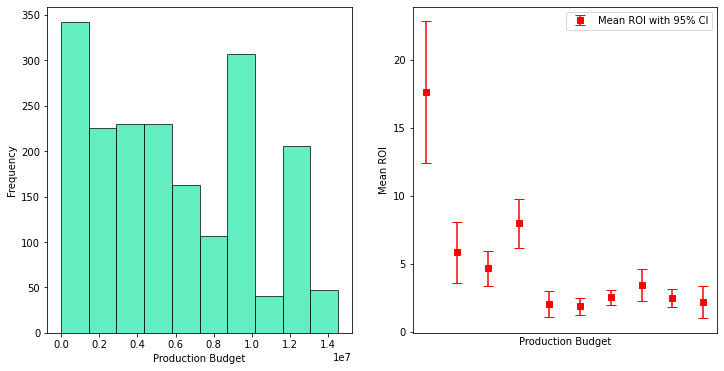

In [74]:
#given they are related, take a look at the distribution of budgets, and what mean ROI's are expected at each level
#plotting the budget distribution for budgets <$15M (anything above considered outlier),
# comparing the ROI confidence intervals for each of the budget bins

budg_df = gen_prof_df[gen_prof_df['production_budget'] < 15 * 10**6][['production_budget', 'ROI']]
num_bins = 10
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for production budget
ax[0].hist(budg_df['production_budget'], bins=num_bins, color='#21E8A7', edgecolor='k', alpha=0.7, label='Production Budget')

# Calculate the mean and confidence interval of 'ROI' for each production_budget bin
production_budget_bins = pd.cut(budg_df['production_budget'], bins=num_bins)
mean_roi_by_budget = budg_df.groupby(production_budget_bins)['ROI'].mean()
std_roi_by_budget = budg_df.groupby(production_budget_bins)['ROI'].std()
n = budg_df.groupby(production_budget_bins)['ROI'].count()
confidence_interval = 1.96 * (std_roi_by_budget / np.sqrt(n))  # 1.96 is the critical z-score for a 95% confidence interval

bin_midpoints = np.arange(num_bins) + 0.5

# ROI confidence interval on separate graph, could not get it on the left histogram?
ax[1].errorbar(bin_midpoints, mean_roi_by_budget, yerr=confidence_interval, fmt='s', color='red', label='Mean ROI with 95% CI', capsize=5)

# Add labels and legend
ax[0].set_xlabel('Production Budget')
ax[1].set_xlabel('Production Budget')
ax[0].set_ylabel('Frequency')
ax[1].set_xticks([])
ax[1].set_ylabel('Mean ROI')
plt.legend()

# Show the plot
plt.show()

In [75]:
#review the ROI details
gen_prof_df['ROI'].describe()

count    5077.000000
mean        3.648782
std        14.667378
min        -1.000000
25%        -0.241780
50%         1.116558
75%         3.099422
max       415.564740
Name: ROI, dtype: float64

In [76]:
#that max level above is super high, take out some of the outliers
gen_prof_df[gen_prof_df['ROI'] < 50]['ROI'].describe()

count    5010.000000
mean        2.385444
std         4.823132
min        -1.000000
25%        -0.260943
50%         1.081692
75%         3.031137
max        42.497008
Name: ROI, dtype: float64

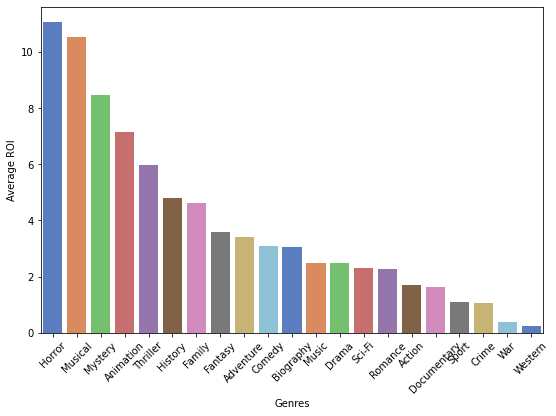

In [77]:
#all datapoints for reference - given outliers, will not include this visual in presentation
gen_inc = gen_prof_df.groupby('genres')['ROI'].mean().sort_values(ascending=False)
fix, ax = plt.subplots(figsize=(9,6))
sns.barplot(x=gen_inc.index, y=gen_inc.values, palette='muted')
ax.set_xlabel('Genres')
ax.set_ylabel('Average ROI')
plt.xticks(rotation=45)
plt.show()

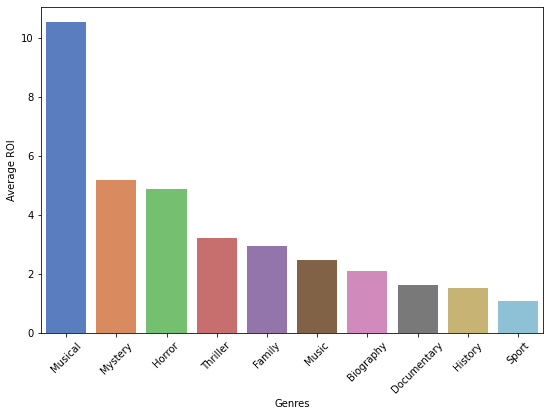

In [113]:
#max outliers taken out - using this one for presentation
#focusing on top 5 genres in terms of both ROI and rating in genre_list
genre_list = ['Horror', 'Mystery', 'Family', 'Musical', 'Thriller', 'Documentary', 'Biography', 'Sport', 'History', 'Music']
gen_inc = gen_prof_df[(gen_prof_df['genres'].isin(genre_list))& (gen_prof_df['ROI'] < 50)].groupby('genres')['ROI'].mean().sort_values(ascending=False)
fix, ax = plt.subplots(figsize=(9,6))
sns.barplot(x=gen_inc.index, y=gen_inc.values, palette='muted')
ax.set_xlabel('Genres')
ax.set_ylabel('Average ROI')
plt.xticks(rotation=45)
plt.show()

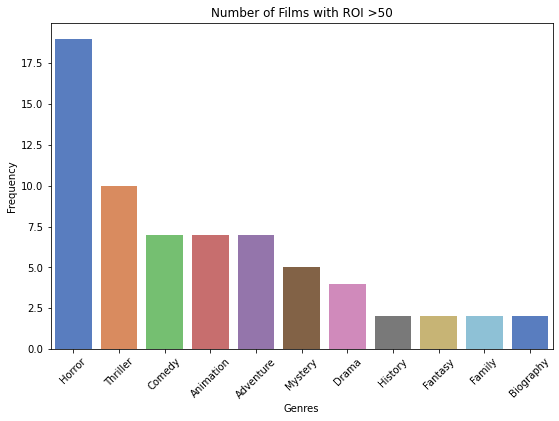

In [119]:
#max outliers only - for reference
gen_inc2 = gen_prof_df[gen_prof_df['ROI'] > 50].groupby('genres')['movie_id'].count().sort_values(ascending=False)
fix, ax = plt.subplots(figsize=(9,6))
sns.barplot(x=gen_inc2.index, y=gen_inc2.values, palette='muted')
ax.set_xlabel('Genres')
ax.set_title('Number of Films with ROI >50')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

[ it's clear that horro/drama/thriller-type films have the highest chance of being a "breakout" film (low budget, high ROI) ]

##### Relationship between ROI and release month:

1. is there a significant relationship with release month and ROI?
1. if so, when is the best time to release any given movie?
    1. when is the best time to release a movie within our top 5 genres determined above?

In [80]:
#does release month have an impact on ROI?
#statistical test to perform: ANOVA?
#H0: there is no statistical significance that release month affects ROI
#H1: yes there is ^^
from scipy.stats import f_oneway

# Group ROI values by release month
groups = [group['ROI'] for _, group in merged_df.groupby('release_month')]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*groups)
print(p_value)

0.007200980338834551


There is statistical significance; plot the release month vs. ROI

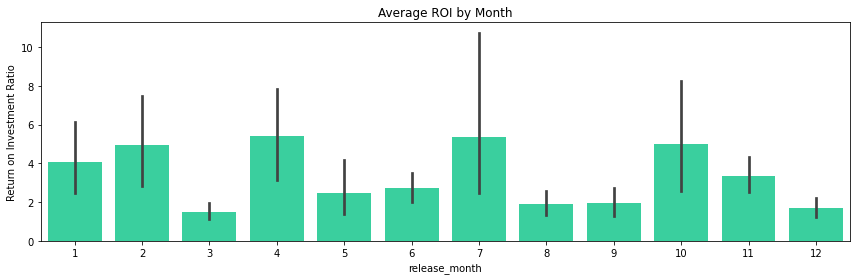

In [81]:
#best time to release a movie
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

#plot first bar chart
sns.barplot(x=merged_df['release_month'], y=merged_df['ROI'], color='#21E8A7')
ax.set_title('Average ROI by Month')
ax.set_ylabel('Return on Investment Ratio')

plt.tight_layout()
plt.show();

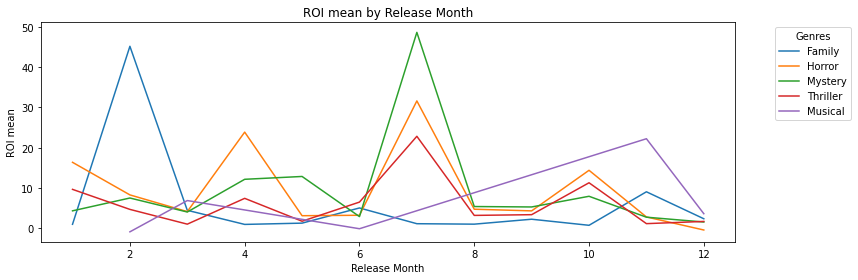

In [82]:
#edit the top_gens variable below to return the genres we want to see by release month
top_gens = ['Horror', 'Mystery', 'Family', 'Musical', 'Thriller']
graph2 = gen_prof_df[gen_prof_df['genres'].isin(top_gens)]

#of the top 5 genres by mean ROI, plot the average ROI by release month for each genre
gen_mean_month = graph2.groupby(['release_month', 'genres'])['ROI'].mean()


plt.figure(figsize=(12, 4)) 
sns.lineplot(data=gen_mean_month, x='release_month', y=gen_mean_month.values, hue='genres')
plt.xlabel('Release Month')
plt.ylabel('ROI mean')
plt.title('ROI mean by Release Month')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Do films where the writer also participates in direction earn on average higher ratings?

In [83]:
#define dataframe with films where the writer participated in directing
writer_directs = imdbdf[(imdbdf['wd_match'] == 1) & (imdbdf['numvotes'] >= 1000)].copy()

#define dataframe with films where the writer did not participate in directing
no_writer_directs = imdbdf[(imdbdf['wd_match'] == 0) & (imdbdf['numvotes'] >= 1000)].copy()

#define dataframe with films where the writer was the only director
writer_only_dir = imdbdf[(imdbdf['w_only_d']) == 2 & (imdbdf['numvotes'] >= 1000)].copy()

#define dataframe with films where the writer was one of many directors
writer_one_of_dir = imdbdf[(imdbdf['w_only_d'] == 1) & (imdbdf['numvotes'] >= 1000)].copy()

In [84]:
#observe means for each group 
writer_directs['averagerating'].mean()
no_writer_directs['averagerating'].mean()
writer_only_dir['averagerating'].mean()
writer_one_of_dir['averagerating'].mean()

6.161230050603348

In [90]:
#test if mean avg. rating for films where writer participates in direction is greater than that of films where the writer did not
#participate in directing

test1 = stats.ttest_ind(writer_directs['averagerating'], no_writer_directs['averagerating'], equal_var=False)#, alternative = 'greater')
test1[1]/2

0.013741511406598402

At a 95% confidence level, films where the writer also directs are on average rated higher than films where the writer is not involved in direction

In [91]:
#test if mean avg. rating for films with one director is greater than that of films with multiple directors
test2 = stats.ttest_ind(imdbdf_onedir['averagerating'], imdbdf_multdir['averagerating'], equal_var=True)#, alternative='greater')
test2[1]/2

6.823801624970963e-20

At a 95% confidence level, movies that have a single director on average are rated higher than movies that have a group of directors  

([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

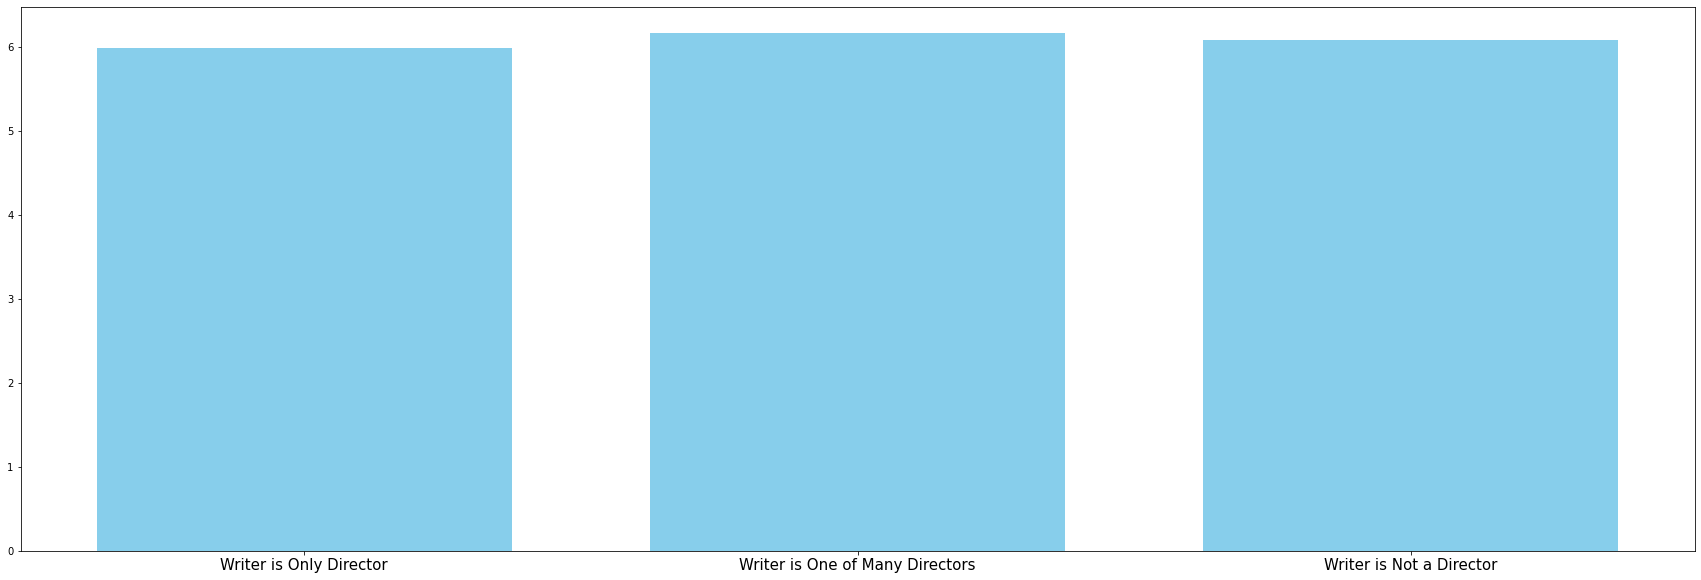

In [92]:
#chart showing average rating of films where writer is only dirctor vs. writer is one of many directors vs. writer is not a director
wdaverages = [writer_only_dir['averagerating'].mean(), writer_one_of_dir['averagerating'].mean(), no_writer_directs['averagerating'].mean()]
labels = ['Writer is Only Director', 'Writer is One of Many Directors', 'Writer is Not a Director']

plt.figure(figsize=(30,10))
plt.bar(labels, wdaverages, color='skyblue', width=0.75)
plt.xticks(fontsize=15)

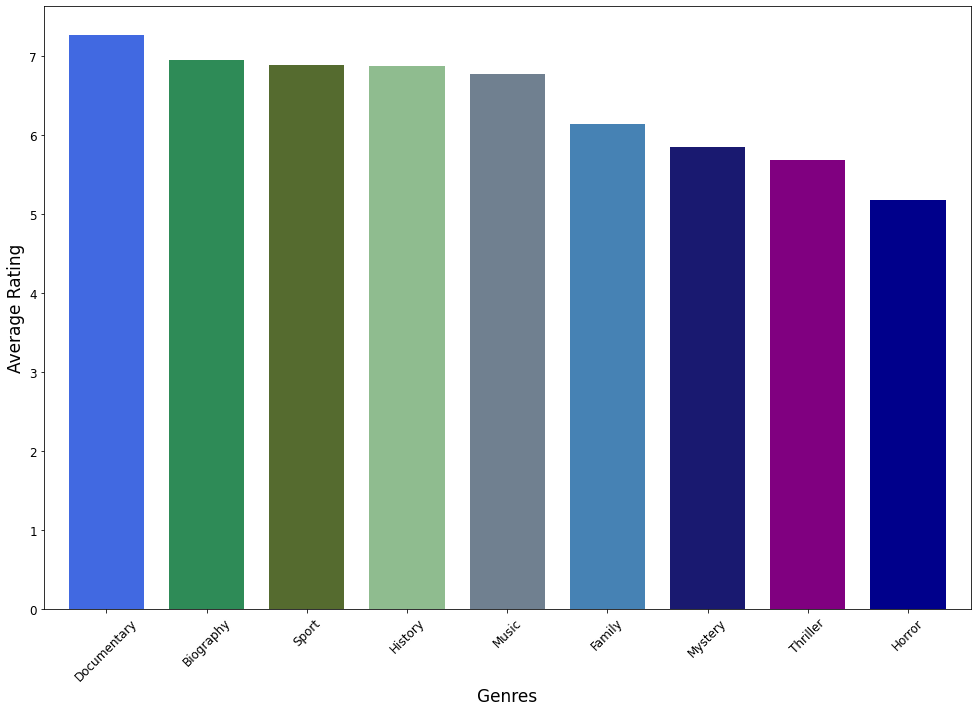

In [121]:
#create chart of average rating by genre
plt.figure(figsize=(13.68,10))

genre_list = ['Horror', 'Mystery', 'Family', 'Musical', 'Thriller', 'Documentary', 'Biography', 'Sport', 'History', 'Music']
genrechart = genredf[genredf.index.isin(genre_list)]

colors = ['#4169E1', '#2E8B57', '#556B2F', '#8FBC8F', '#708090', '#4682B4', '#191970', '#800080', '#00008B', '#5F9EA0', '#4682B4', '#FFA07A', '#CD5C5C', '#FF6347', '#FF4500']


genrechart['averagerating'].plot(kind='bar', color=colors, width=0.75)
plt.xlabel('Genres', fontsize=17)
plt.ylabel('Average Rating', fontsize=17)
#plt.title('Avg. Rating by Genre', fontsize=40)
plt.xticks(rotation=45, fontsize=12) 
plt.yticks(rotation=0, fontsize=12) 
plt.tight_layout()
plt.show()

Documentary, Biography, Sport, History, and Music are the top five genres with the avg. highest rating per IMDb

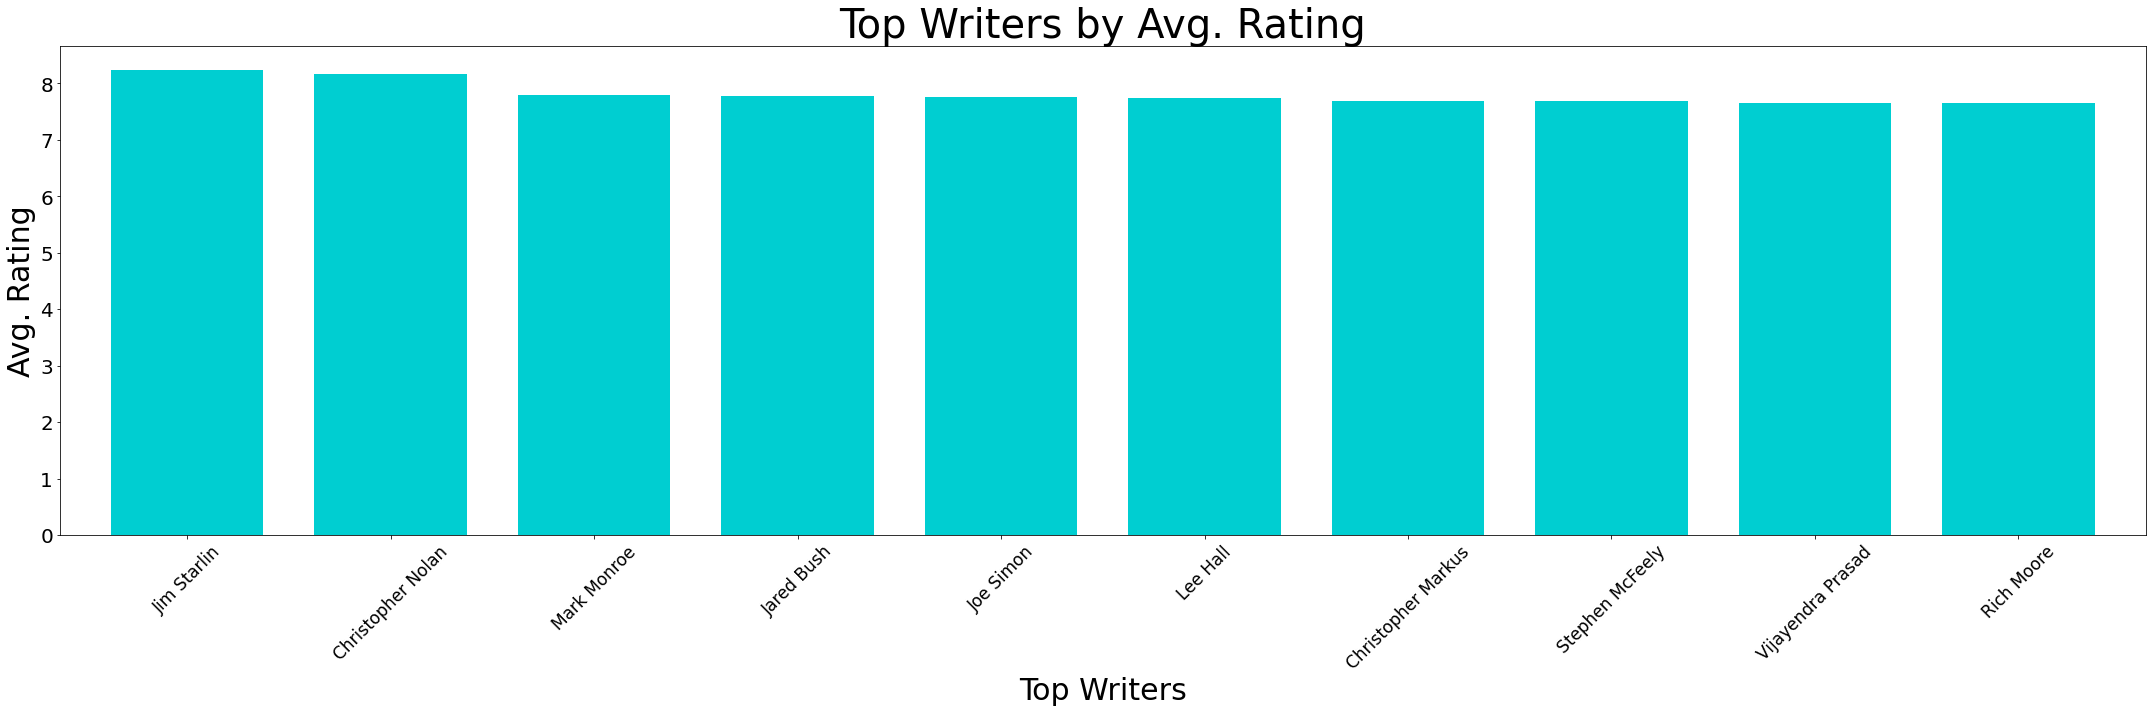

In [94]:
#create chart with top ten writers with the highest average rated films. Inlcude only writers who have written at least 5 movies as we
#want to work with experienced writers. 

plt.figure(figsize=(30,10))

writersratingschart = writersratings.head(10)
writersratingschart.set_index('writer_name', inplace=True)
writersratingschart['averagerating'].plot(kind='bar', color='darkturquoise', width=0.75)
plt.xlabel('Top Writers', fontsize=30)
plt.ylabel('Avg. Rating', fontsize=30)
plt.title('Top Writers by Avg. Rating', fontsize=40)
plt.xticks(rotation=45, fontsize=17) 
plt.yticks(rotation=0, fontsize=20) 
plt.tight_layout()
plt.show()

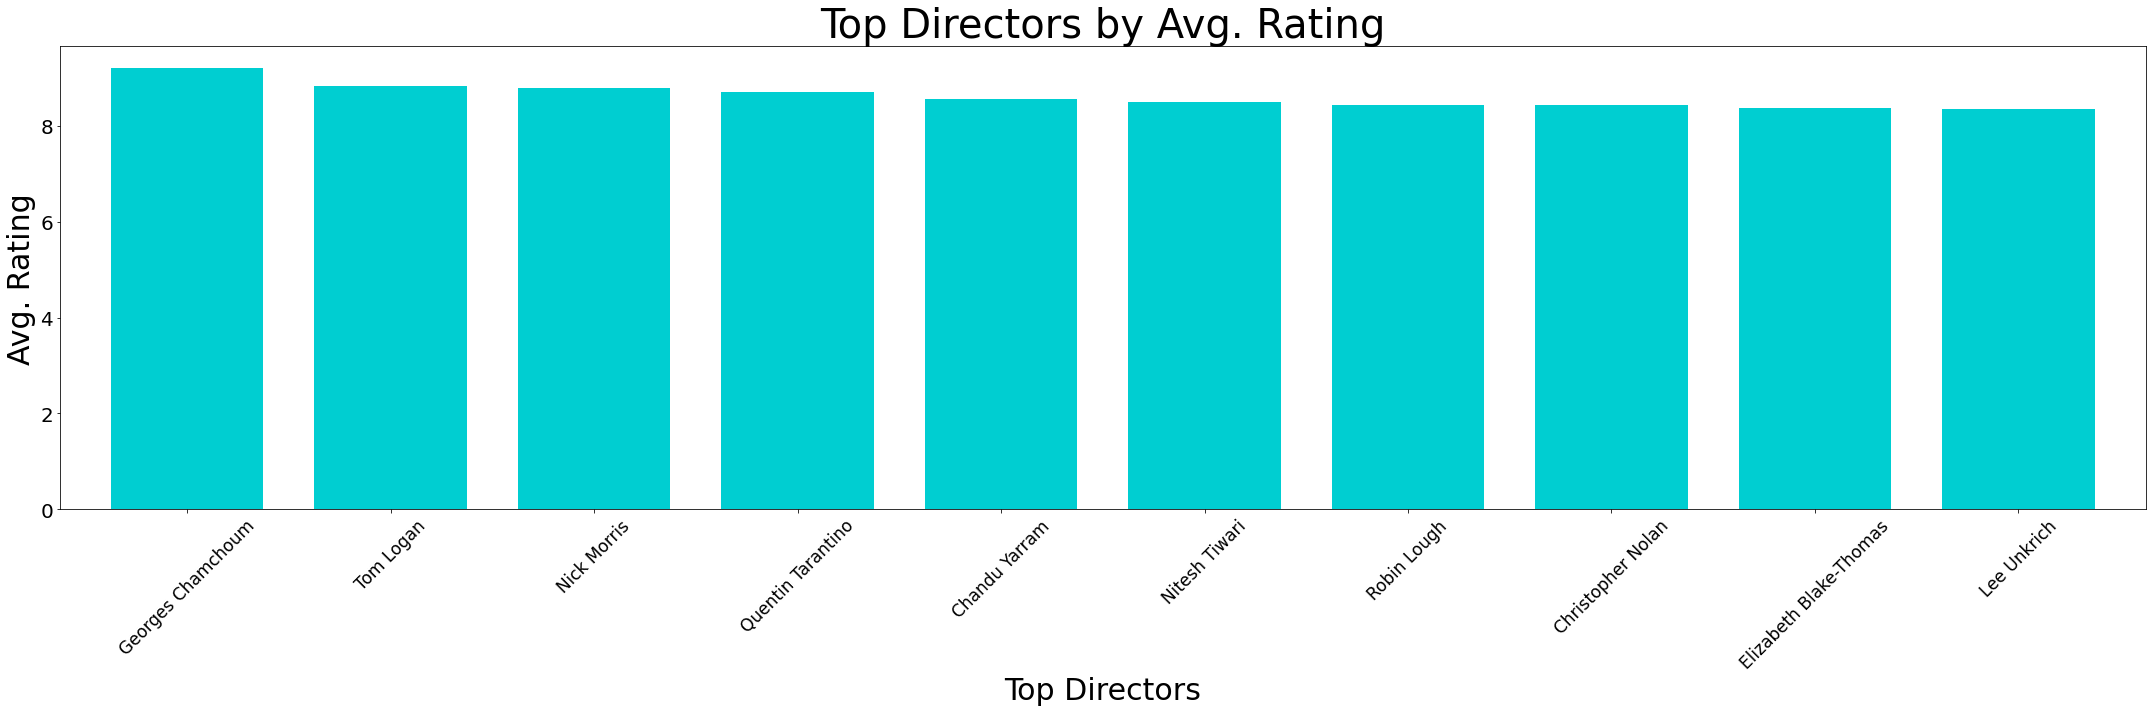

In [95]:
#create chart with top ten directors with the highest average rated films. Inlcude only directors who have directed at least 5 movies as we
#want to work with experienced directors. 

plt.figure(figsize=(30,10))

directorsratingschart = directorsratings.head(10)
directorsratingschart.set_index('director_name', inplace=True)
directorsratingschart['averagerating'].plot(kind='bar', color='darkturquoise', width=0.75)
plt.xlabel('Top Directors', fontsize=30)
plt.ylabel('Avg. Rating', fontsize=30)
plt.title('Top Directors by Avg. Rating', fontsize=40)
plt.xticks(rotation=45, fontsize=17) 
plt.yticks(rotation=0, fontsize=20) 
plt.tight_layout()
plt.show()

In [96]:
#create chart of top 10 directors with the highest average rated films who were the sole director on films.
plt.figure(figsize=(30,10))

onedirchart = imdbdf_onedir_avgrat.head(10)
onedirchart.set_index('director_name', inplace=True)
onedirchart['averagerating'].plot(kind='bar', color='darkturquoise', width=0.75)
plt.xlabel('Top Solo Directors', fontsize=30)
plt.ylabel('Avg. Rating', fontsize=30)
plt.title('Top Solo Directors by Avg. Rating', fontsize=40)
plt.xticks(rotation=45, fontsize=17) 
plt.yticks(rotation=0, fontsize=20) 
plt.tight_layout()
plt.show()

KeyError: "None of ['director_name'] are in the columns"

<Figure size 2160x720 with 0 Axes>

## CONCLUSION SECTION

With the below insights driving decision making, we are beyond excited for what the future holds at RE Studios and are confident success is imminent.

1. We intend on pursuing projects that require ~$4M in funding and believe with 95% confidence, these films will have a mean ROI between 8-12x investment
1. We'll focus on the following genres to optimize ROI and ratings: i) Musical, ii) Animation, iii) Family, iv) Mystery, and Horror
1. We will plan our releases for February, July, October, and November, as films released in these months have historically had the highest average ROI's, and we have devised a genre based annual release schedule
1. We'll aim to work with writers and directors whose prior films are highly rated in comparison to peers, and we will encourage writers to participate in direction

## Additional Considerations & Next Steps

1. We'd like to dive deeper into how budget and ROI are related on a by genre basis
1. As we are planning on producing films with relatively low budgets, we'd like to perform additional analysis regarding the percentage of low budget films that achieve success and produce high returns
1. In choosing films and hiring directors, we'd like to perform cost saving analysis associated with having writers participate in direction of their films

# APPENDIX (ARCHIVE)

### Archived Code: for reference in other visualizations explored

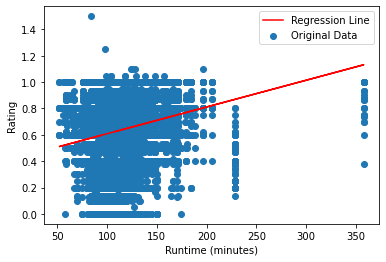

In [97]:
#Question: do movies with "long" runtimes last longer in theaters than movies with "short" runtimes?
#Issuse with below graph:
# 1. when I try to filter out ratings >1, throws a NaN error
# 2. need to apply filter for films with runtimes in two outlier buckets - must be error
# 3. maybe a histplot with runtime bins would be more appropriate?
####################
model2_df = total_rt[total_rt['runtime'].notna() & total_rt['Numeric_rating'].notna()]# & total_rt['Numeric_rating'] < 1.001]
model2 = LinearRegression()
X = model2_df[['runtime']]
Y = model2_df['Numeric_rating']
model2.fit(X, Y)
intercept = model2.intercept_
slope = model2.coef_[0]

Y_pred = model2.predict(X)

plt.scatter(X, Y, label='Original Data')
plt.plot(X, Y_pred, color='red', label='Regression Line')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Rating')
plt.legend()
plt.show()

#################

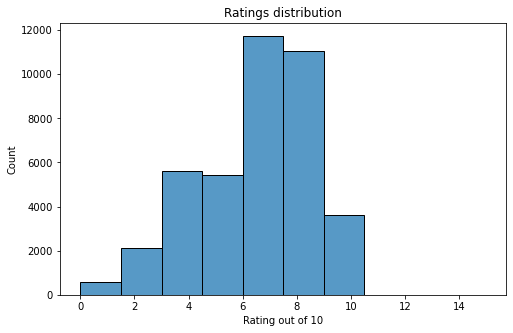

In [98]:
x = total_rt[total_rt['Numeric_rating'].notna()]['Numeric_rating'].apply(lambda x: x*10)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.histplot(data=x, bins = 10)
ax.set_title('Ratings distribution')
ax.set_xlabel('Rating out of 10');

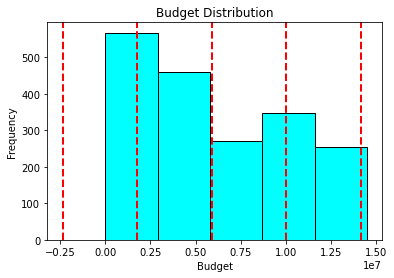

In [99]:
#evaluating budget taking outliers out
Q = gen_prof_df[gen_prof_df['production_budget'] < 15 * 10**6][['production_budget', 'ROI']]
plt.hist(Q['production_budget'], bins=5, color='cyan', edgecolor='black')

# Customize the plot
plt.title('Budget Distribution')
plt.xlabel('Budget')
plt.ylabel('Frequency')

#standard deviation lines
for i in range(-2, 3): 
    plt.axvline(Q['production_budget'].mean() + i * Q['production_budget'].std(), color='red', linestyle='dashed', linewidth=2)

# Show the histogram
plt.show()

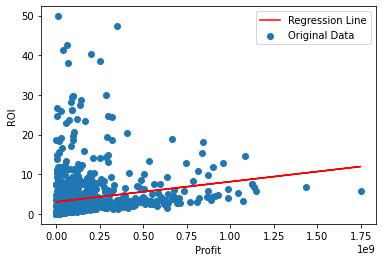

In [100]:
#Profit bins vs. ROI linear regression
#potential to show that budget and revenue (or profit, however variables work) are not necessarily dependent on each other (without profit calc)
##############
scatter2 = gen_prof_df[gen_prof_df['profit'].notna() & gen_prof_df['ROI'] < 200].groupby('movie_id').mean()[['profit', 'ROI']]
scatter2 = scatter2[(scatter2['ROI'] > 0) & (scatter2['ROI'] < 50)]
model3 = LinearRegression()
X = scatter2[['profit']]
Y = scatter2['ROI']
model3.fit(X, Y)
intercept = model3.intercept_
slope = model3.coef_[0]
Y_pred = model3.predict(X)

plt.scatter(X, Y, label='Original Data')
plt.plot(X, Y_pred, color='red', label='Regression Line')
plt.xlabel('Profit')
plt.ylabel('ROI')
plt.legend()
plt.show()

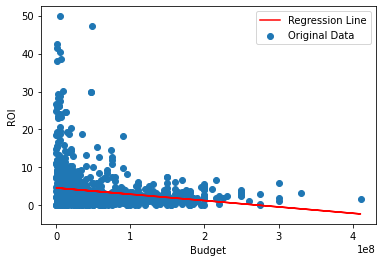

In [101]:
#Budget vs. ROI linear regression
##############
scatter2 = gen_prof_df[(gen_prof_df['production_budget'].notna() & gen_prof_df['production_budget'] < (15 * (10**6))) & (gen_prof_df['ROI'] < 200)].groupby('movie_id').mean()[['production_budget', 'ROI']]
scatter2 = scatter2[(scatter2['ROI'] > 0) & (scatter2['ROI'] < 50)]
model3 = LinearRegression()
X = scatter2[['production_budget']]
Y = scatter2['ROI']
model3.fit(X, Y)
intercept = model3.intercept_
slope = model3.coef_[0]
Y_pred = model3.predict(X)

plt.scatter(X, Y, label='Original Data')
plt.plot(X, Y_pred, color='red', label='Regression Line')
plt.xlabel('Budget')
plt.ylabel('ROI')
plt.legend()
plt.show()

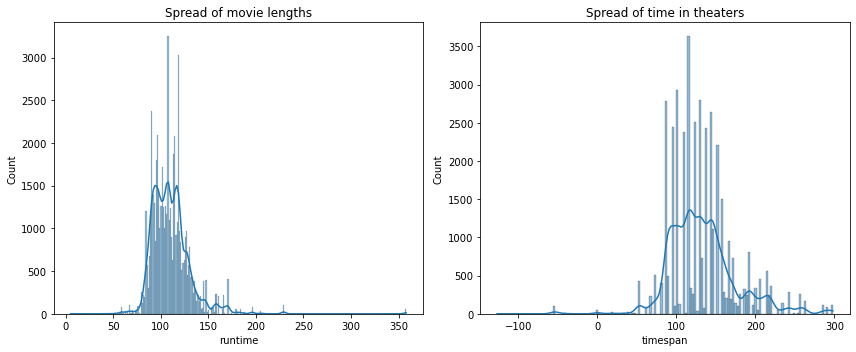

In [102]:
#is there anything to compare movie lengths to

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#plot first histogram
sns.histplot(data=total_rt['runtime'], kde=True, ax=axes[0])
axes[0].set_title('Spread of movie lengths')

#plot second
sns.histplot(data=total_rt[total_rt['timespan'] <300]['timespan'], kde=True, ax=axes[1])
axes[1].set_title('Spread of time in theaters')

plt.tight_layout()
plt.show();

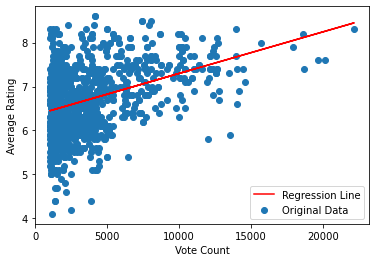

In [103]:
model1 = LinearRegression()
reg_df = tmdb_df[tmdb_df['vote_count'] > 1000]
X = reg_df[['vote_count']]
Y = reg_df['vote_average']
model1.fit(X, Y)
intercept = model1.intercept_
slope = model1.coef_[0]

Y_pred = model1.predict(X)

plt.scatter(X, Y, label='Original Data')
plt.plot(X, Y_pred, color='red', label='Regression Line')
plt.xlabel('Vote Count')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

#### Is there a linear relationship between runtime and average rating?

In [104]:
#create and run linear regression model comparing runtime to average rating
endog = imdbdf['averagerating']
exog = sm.add_constant(imdbdf['runtime_minutes'])
model_runtime = sm.OLS(endog, exog).fit()
model_runtime.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          averagerating   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     639.2
Date:                Thu, 14 Sep 2023   Prob (F-statistic):          1.00e-138
Time:                        15:24:09   Log-Likelihood:                -33322.
No. Observations:               18922   AIC:                         6.665e+04
Df Residuals:                   18920   BIC:                         6.666e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.5840      0.051     90.349      0.000       4.485       4.683
runtime_minutes     0.0132      0.001     25.282      0.000       0.012       0.014
==============================================================================
Omnibus:                      434.320   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              464.638
Skew:                          -0.384   Prob(JB):                    1.27e-101
Kurtosis:                       2.992   Cond. No.                         482.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

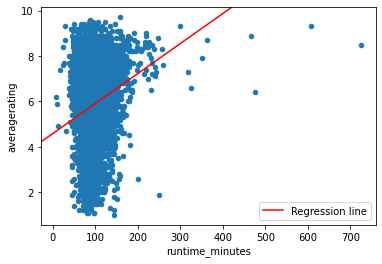

In [105]:
#plot scatter plot with regression line
fig, ax = plt.subplots()
imdbdf.plot.scatter(x='runtime_minutes', y='averagerating', ax=ax)
sm.graphics.abline_plot(model_results=model_runtime, label="Regression line", ax=ax, color='red')
ax.legend()

As the R-squared is close to 0, there is little to no linear relationship between runtime and rating; however there are a handful of outliers that may be impacting these results.

<AxesSubplot:xlabel='runtime_minutes', ylabel='averagerating'>

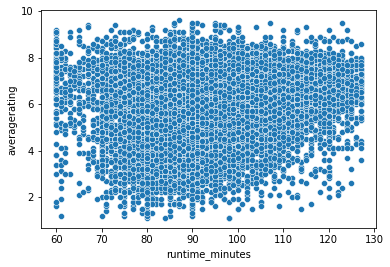

In [106]:
#remove runtime_minutes outliers and plot scatter plot of runtime vs. average rating.
#appears to be no linear correlation but lets run model to check
imdbdf_runtime = imdbdf
lower = imdbdf_runtime['runtime_minutes'].quantile(0.25) - 1.5 * (imdbdf_runtime['runtime_minutes'].quantile(0.75) - imdbdf_runtime['runtime_minutes'].quantile(0.25))
upper = imdbdf_runtime['runtime_minutes'].quantile(0.75) + 1.5 * (imdbdf_runtime['runtime_minutes'].quantile(0.75) - imdbdf_runtime['runtime_minutes'].quantile(0.25))
imdbdf_runtime = imdbdf_runtime[(imdbdf_runtime['runtime_minutes'] >= lower) & (imdbdf_runtime['runtime_minutes'] <= upper)]
sns.scatterplot(x='runtime_minutes', y='averagerating', data=imdbdf_runtime)

In [107]:
#rerun linear regression using dataset that excludes runtime outliers 
endog = imdbdf_runtime['averagerating']
exog = sm.add_constant(imdbdf_runtime['runtime_minutes'])
model_runtime_two = sm.OLS(endog, exog).fit()
model_runtime_two.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          averagerating   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     512.2
Date:                Thu, 14 Sep 2023   Prob (F-statistic):          8.22e-112
Time:                        15:24:11   Log-Likelihood:                -31055.
No. Observations:               17728   AIC:                         6.211e+04
Df Residuals:                   17726   BIC:                         6.213e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.9872      0.080     49.982      0.000       3.831       4.144
runtime_minutes     0.0192      0.001     22.631      0.000       0.018       0.021
==============================================================================
Omnibus:                      289.165   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.695
Skew:                          -0.318   Prob(JB):                     1.86e-66
Kurtosis:                       2.927   Cond. No.                         717.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

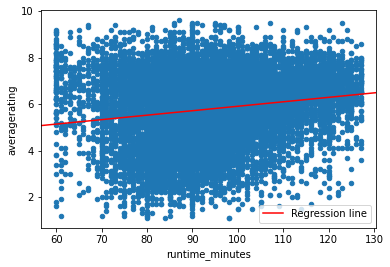

In [108]:
#plot runtime vs. average rating (excl. outliers) with regression line
fig, ax = plt.subplots()
imdbdf_runtime.plot.scatter(x='runtime_minutes', y='averagerating', ax=ax)
sm.graphics.abline_plot(model_results=model_runtime_two, label="Regression line", ax=ax, color='red')
ax.legend()

Even with outliers removed, there remains only a weak to non-existent linear correlation between runtime and average rating as R-squared is again very close to zero. 